
# **Loan Default Prediction – LendingClub**  
Data Mining – Evaluation II

This notebook follows the assignment steps end‑to‑end: data cleaning, EDA, correlation mapping, feature engineering & selection, preprocessing, model training, tuning, and evaluation (Precision, Recall, F1, Confusion Matrix, ROC‑AUC), plus a short discussion and conclusions.



## 0) Setup & Data Loading

**Option A (Upload manually):** In Colab, go to `Files` (left panel) → Upload `lending_club_loan_two.csv` and set `DATA_PATH` accordingly.  
**Option B (Kaggle API):** Uncomment the Kaggle cell and add your Kaggle API token.


In [7]:
DATA_PATH = 'lending_club_loan_two.csv'  # update if needed
# Quick check (will fail until the file exists)
import os
print('File exists?', os.path.exists(DATA_PATH))

File exists? True


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)


## 1) Understanding the dataset & business context

- **Business objective:** Predict the likelihood that a loan will be **charged off** (default) at origination to minimize financial risk (reduce false positives) without rejecting too many reliable borrowers (reduce false negatives).

In [9]:
df = pd.read_csv(DATA_PATH)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [10]:
df.shape, df.dtypes.value_counts()

((396030, 27),
 object     15
 float64    12
 Name: count, dtype: int64)

In [11]:
# Binary target: 1 = Charged Off (default), 0 = Fully Paid
df['default'] = (df['loan_status'].str.strip().str.lower() == 'charged off').astype(int)
df['default'].value_counts()

default
0    318357
1     77673
Name: count, dtype: int64


## 2) Data cleaning & 3) EDA
- Handle missing values
- Engineer useful features (e.g., `term_months`, `emp_length_years`, `credit_age_years`)
- Remove high-cardinality text columns that add noise
- Explore class balance & descriptive statistics
- Correlation map and multicollinearity comments


In [12]:
def parse_term(term):
    if pd.isna(term): return np.nan
    digits = ''.join([ch for ch in str(term) if ch.isdigit()])
    return float(digits) if digits else np.nan

def parse_emp_length(val):
    if pd.isna(val): return np.nan
    s = str(val).strip()
    if s == '10+ years': return 10.0
    if s == '< 1 year': return 0.0
    if s == '1 year': return 1.0
    if 'years' in s:
        try:
            return float(s.split()[0])
        except:
            return np.nan
    return np.nan

def to_dt(s):
    for fmt in ('%b-%Y', None):
        try:
            return pd.to_datetime(s, format=fmt) if fmt else pd.to_datetime(s)
        except:
            continue
    return pd.NaT

df['term_months'] = df['term'].map(parse_term)
df['emp_length_years'] = df['emp_length'].map(parse_emp_length)
df['issue_dt'] = df['issue_d'].apply(to_dt)
df['earliest_dt'] = df['earliest_cr_line'].apply(to_dt)
df['credit_age_years'] = ((df['issue_dt'] - df['earliest_dt']).dt.days / 365.25)
df['issue_year'] = df['issue_dt'].dt.year
df['issue_month'] = df['issue_dt'].dt.month

# Drop redundant/noisy text columns
drop_cols = ['loan_status','term','emp_length','issue_d','earliest_cr_line','title','emp_title','address','grade']
df_model = df.drop(columns=drop_cols, errors='ignore')

y = df_model['default'].values
X = df_model.drop(columns=['default'])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print('Numeric cols:', len(numeric_cols))
print('Categorical cols:', len(categorical_cols))
df_model[numeric_cols].describe().T.iloc[:15]

Numeric cols: 17
Categorical cols: 6


,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.000000,8000.000000,12000.000000,20000.000000,4.000000e+04
int_rate,396030.0,13.639400,4.472157,5.320000,10.490000,13.330000,16.490000,3.099000e+01
installment,396030.0,431.849698,250.727790,16.080000,250.330000,375.430000,567.300000,1.533810e+03
annual_inc,396030.0,74203.175798,61637.621158,0.000000,45000.000000,64000.000000,90000.000000,8.706582e+06
dti,396030.0,17.379514,18.019092,0.000000,11.280000,16.910000,22.980000,9.999000e+03
open_acc,396030.0,11.311153,5.137649,0.000000,8.000000,10.000000,14.000000,9.000000e+01
pub_rec,396030.0,0.178191,0.530671,0.000000,0.000000,0.000000,0.000000,8.600000e+01
revol_bal,396030.0,15844.539853,20591.836109,0.000000,6025.000000,11181.000000,19620.000000,1.743266e+06
revol_util,395754.0,53.791749,24.452193,0.000000,35.800000,54.800000,72.900000,8.923000e+02
total_acc,396030.0,25.414744,11.886991,2.000000,17.000000,24.000000,32.000000,1.510000e+02


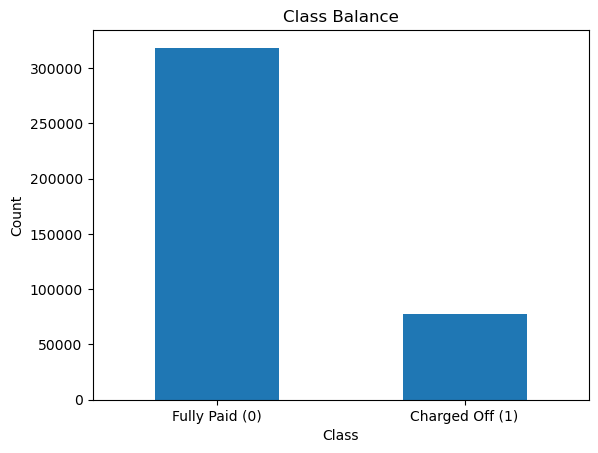

Fully Paid (0)     318357
Charged Off (1)     77673
Name: count, dtype: int64

In [13]:

# Class balance
class_counts = pd.Series(y).value_counts().rename({0:'Fully Paid (0)',1:'Charged Off (1)'})
class_counts.plot(kind='bar', rot=0)
plt.title('Class Balance')
plt.xlabel('Class'); plt.ylabel('Count')
plt.show()
class_counts

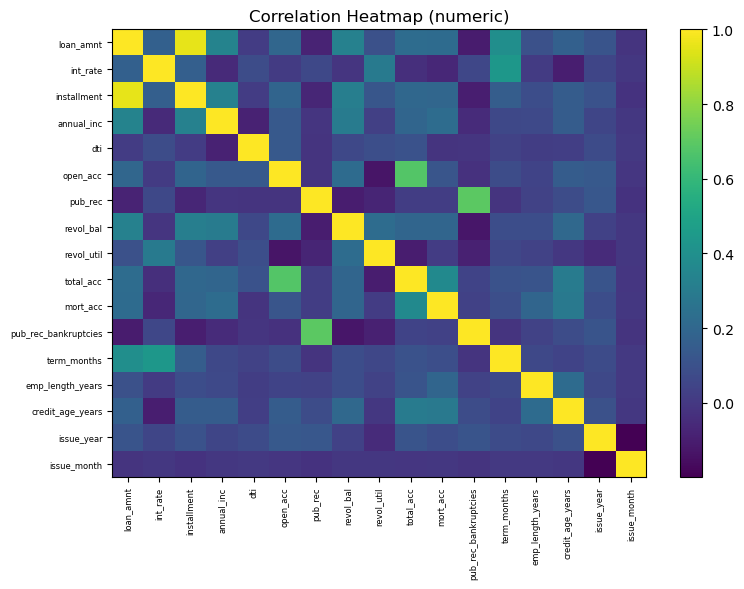

In [14]:

# Correlation heatmap (numeric only; be careful interpreting OHE features later)
num_df = X[numeric_cols].copy()
for c in num_df.columns:
    if num_df[c].isna().any():
        num_df[c] = num_df[c].fillna(num_df[c].median())
corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.colorbar(); plt.title('Correlation Heatmap (numeric)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.index)), corr.index, fontsize=6)
plt.tight_layout()
plt.show()


## 4) Feature selection
We use **mutual information** to score features against the target and select the top‑K. This helps reduce noise and multicollinearity effects after one‑hot encoding.


In [15]:

# Preprocessing for MI (simple imputation + OHE). We'll compute MI on a sample for speed.
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

# Temporary: impute & encode categoricals as ordinal for MI speed (approximation)
X_mi = X.copy()
for c in X_mi.select_dtypes(include=[np.number]).columns:
    X_mi[c] = X_mi[c].fillna(X_mi[c].median())

cat_cols = X_mi.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_mi[cat_cols] = enc.fit_transform(X_mi[cat_cols].astype(str))

mi = mutual_info_classif(X_mi, y, discrete_features=[X_mi[c].dtype != float for c in X_mi.columns], random_state=42)
mi_series = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)
mi_series.head(20)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>)

In [ ]:

# Choose K features (tune K as you like). We'll keep a generous set to avoid losing signal.
K = min(40, X.shape[1])
top_features = mi_series.head(K).index.tolist()
top_features


## 5) Data preprocessing & splitting
We use a `ColumnTransformer` for numeric/categorical pipelines and keep only the top‑K features selected above. Then we do a **stratified** train/test split.


In [ ]:

X_sel = X[top_features].copy()

num_cols = X_sel.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_sel.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols),
                                  ('cat', categorical_transformer, cat_cols)])

X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape, pd.Series(y_train).value_counts(normalize=True)


## 6) Model training & 7) Hyperparameters
We train three models:
- **Logistic Regression** (baseline, interpretable)
- **Random Forest** (nonlinear, robust)
- **HistGradientBoosting** (fast boosting baseline)

We define key hyperparameters and tune them via **RandomizedSearchCV**.


In [ ]:

models = {
    'log_reg': LogisticRegression(max_iter=3000, class_weight='balanced', solver='lbfgs'),
    'rf': RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1),
    'hgb': HistGradientBoostingClassifier(random_state=42)
}

param_spaces = {
    'log_reg': {'clf__C': np.logspace(-2, 2, 12)},
    'rf': {
        'clf__n_estimators': [200, 300, 500],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['sqrt', 'log2', None],
    },
    'hgb': {
        'clf__max_depth': [None, 4, 8, 12],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__max_iter': [100, 200, 300],
        'clf__l2_regularization': [0.0, 0.01, 0.1]
    }
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_models = {}
for name, clf in models.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    search = RandomizedSearchCV(
        pipe, param_spaces[name], n_iter=15, scoring='roc_auc',
        cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(name, 'best params:', search.best_params_)


## 8) Tuning impact & 9) Evaluation
We evaluate each model on the test set and compare **Precision, Recall, F1 (by class)**, **Confusion Matrix**, and **ROC‑AUC**.


In [ ]:

def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = None
    rep = classification_report(y_test, y_pred, output_dict=True, digits=4)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    print(f'\n{name} | ROC-AUC: {auc:.4f}')
    print(pd.DataFrame(rep).T[['precision','recall','f1-score','support']].head(3))
    print('Confusion Matrix:\n', cm)
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'ROC – {name} (AUC={auc:.3f})')
        plt.show()
    return {'model': name, 'roc_auc': auc,
            'precision_1': rep['1']['precision'], 'recall_1': rep['1']['recall'], 'f1_1': rep['1']['f1-score']}

rows = []
for name, model in best_models.items():
    rows.append(evaluate_model(name, model))

pd.DataFrame(rows).sort_values('roc_auc', ascending=False)


## Discussion
1. **Best balance:** Explain which model achieved the best tradeoff between **recall** (catch risky borrowers) and **precision** (avoid wrongly flagging reliable borrowers), and why that matters to LendingClub.
2. **Effect of tuning:** Summarize how the hyperparameters changed the model behavior (e.g., RF depth vs. overfitting; LR regularization `C`; HGB learning rate/iterations).
3. **Conclusion:** How you would deploy the chosen model (threshold tuning, risk tiers, manual review flags) to minimize financial risk while preserving approval rates.
